In [1]:
pip install pydicom matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import glob
import pydicom
import matplotlib.pyplot as plt

def load_and_display_dicom_images(directory):
    # Get a list of all files in the directory
    dicom_files = []
    for image_path in glob.glob(os.path.join(directory, '*')):
        if os.path.isfile(image_path):  # Check if the path is a file (not a directory)
            try:
                dicom_file = pydicom.dcmread(image_path)
                dicom_files.append(dicom_file)
            except Exception as e:
                print(f"Error reading {image_path}: {e}")
    
    # Check if any DICOM files were found
    if not dicom_files:
        print(f"No DICOM files found in directory: {directory}")
        return
    
    # Display each DICOM file
    for i, dicom_data in enumerate(dicom_files):
        try:
            # Check if pixel data is present
            if hasattr(dicom_data, 'pixel_array'):
                # Extract the image data
                image = dicom_data.pixel_array
                
                # Plot the image
                plt.figure(figsize=(6, 6))
                plt.imshow(image, cmap='gray')
                plt.title(f"Image {i+1} from {os.path.basename(dicom_data.filename)}")
                plt.axis('off')
                plt.show()
            else:
                print(f"No pixel data found in file: {dicom_data.filename}")
        except Exception as e:
            print(f"Error processing file {dicom_data.filename}: {e}")

# Example usage:
dicom_directory = '/Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_28/9730895c1e/t1_vibe_we'  # Replace with the path to your DICOM files
load_and_display_dicom_images(dicom_directory)


In [2]:
from pre_processing_py import HandScanDataset2, transform, validation_transform, train_df, valid_df, training_data_dir, display_images
from timm.models.layers import DropPath, trunc_normal_
import numpy as np

Batch image shape: torch.Size([1, 1, 6, 512, 384])
Batch label shape: torch.Size([1])


In [3]:
import torch
# Initialize the dataset
dataset = HandScanDataset2(labels_df=train_df, data_dir=training_data_dir, transform=transform)

# Use DataLoader to get a batch of images
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)


TypeError: Invalid shape (6, 512, 384) for image data

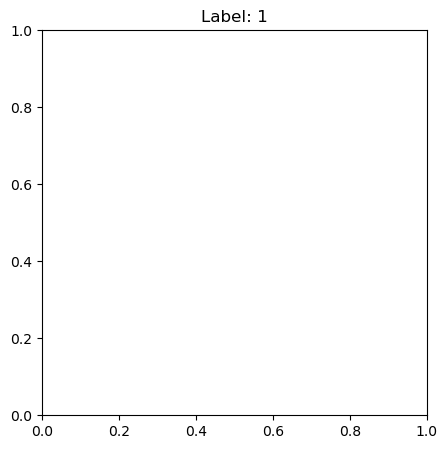

In [4]:
import matplotlib.pyplot as plt
def show_images(dataset, num_images=4):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(dataloader))

    for i in range(num_images):
        image = images[i]  # Remove the channel dimension
        label = labels[i].item()
        
        plt.figure(figsize=(5, 5))
        plt.title(f'Label: {label}')
        plt.imshow(image[0], cmap='gray')  # Assuming images are grayscale
        plt.axis('off')
        plt.show()

# Show a few images from the dataset
show_images(dataset, num_images=4)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.utils.data import DataLoader, Dataset
import numpy as np
from datetime import datetime



In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=(1, 4, 4), embed_dim=64):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, D/patch_size, H/patch_size, W/patch_size)
        x = rearrange(x, 'b c d h w -> b (d h w) c')  # Flatten to (B, N, embed_dim)
        return x


In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4.0):
        super(TransformerBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.norm1(x + self.attn(x, x, x)[0])
        x = self.norm2(x + self.mlp(x))
        return x


In [8]:
class DisruptiveAutoencoder(nn.Module):
    def __init__(self, in_channels=1, patch_size=(1, 4, 4), embed_dim=64, depth=4, num_heads=4, mlp_ratio=4.0):
        super(DisruptiveAutoencoder, self).__init__()
        
        # Encoder
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)
        self.encoder_layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        
        # Decoder
        self.decoder_layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        self.reconstruction_head = nn.Linear(embed_dim, np.prod(patch_size) * in_channels)

    def forward(self, x):
        original_shape = x.shape  # Save the original shape
        
        x = self.patch_embed(x)
        
        # Encoder
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Decoder
        for layer in self.decoder_layers:
            x = layer(x)
        
        # Reconstruction
        x = self.reconstruction_head(x)
        
        # Reshape back to original dimensions before applying L1 loss
        d_patches, h_patches, w_patches = 3, 64, 48  # Adjust based on your input size and patch_size
        x = rearrange(x, 'b (d h w) (p1 p2 p3 c) -> b c (d p1) (h p2) (w p3)', d=d_patches, h=h_patches, w=w_patches, p1=1, p2=4, p3=4)
        
        # Upsample to the original shape
        x = F.interpolate(x, size=original_shape[2:], mode='trilinear', align_corners=False)
        
        return x

    def add_noise(self, x, noise_level=0.1):
        noise = torch.randn_like(x) * noise_level
        return x + noise

    def downsample(self, x, scale_factor=0.5):
        """
        This method downsamples the input by a given scale factor.
        """
        return F.interpolate(x, scale_factor=scale_factor, mode='trilinear', align_corners=False)

    def local_mask(self, x, mask_ratio=0.15):
        b, c, d, h, w = x.shape
        num_masked = int(mask_ratio * c)
        mask_indices = torch.randperm(c)[:num_masked]
        x[:, mask_indices, :, :, :] = 0
        return x

    def compute_loss(self, reconstructed, original, zsim, zlabel, alpha=0.05):
        reconstructed = F.interpolate(reconstructed, size=original.shape[2:], mode='trilinear', align_corners=False)
        l1_loss = F.l1_loss(reconstructed, original)
        bce_loss = F.binary_cross_entropy_with_logits(zsim, zlabel)
        contrastive_loss = alpha * bce_loss
        total_loss = l1_loss + contrastive_loss
        return total_loss, l1_loss, contrastive_loss


In [9]:
batch_size = 1
test_subjects_df = train_df.iloc[:3]
# Initialize dataset and data loader
train_dataset = HandScanDataset2(labels_df=test_subjects_df, data_dir=training_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
valid_subjects_df = valid_df.iloc[:3]
# Initialize the dataset with the selected subjects
valid_dataset = HandScanDataset2(labels_df=valid_subjects_df, data_dir=training_data_dir, transform=validation_transform)
# Create a data loader for testing
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [11]:
'''
# Select a few subjects (e.g., the first three subjects)
test_subjects_df = train_df.iloc[:3]

# Initialize the dataset with the selected subjects
test_dataset = HandScanDataset2(labels_df=test_subjects_df, data_dir=training_data_dir, transform=transform)

# Create a data loader for testing
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
'''

'\n# Select a few subjects (e.g., the first three subjects)\ntest_subjects_df = train_df.iloc[:3]\n\n# Initialize the dataset with the selected subjects\ntest_dataset = HandScanDataset2(labels_df=test_subjects_df, data_dir=training_data_dir, transform=transform)\n\n# Create a data loader for testing\ntest_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)\n'

In [12]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.activation_count = 0

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.activation_count += 1
                return True
        return False


In [13]:
def visualize_reconstruction(dae_model, patches, idx, device, num_slices=1):
    """
    Visualizes the original, tokenized patches, and reconstructed images.

    Args:
        dae_model (nn.Module): The trained autoencoder model.
        patches (torch.Tensor): The input patches.
        idx (int): Index of the image (used for title).
        device (torch.device): The device to which the model and data are moved.
        num_slices (int): Number of slices to visualize.
    """
    dae_model.eval()  # Set the model to evaluation mode
    
    # Move patches to the appropriate device
    patches = patches.to(device)

    with torch.no_grad():
        # Forward pass to get the intermediate and final outputs
        noisy_patches = dae_model.add_noise(patches)
        downsampled_patches = dae_model.downsample(noisy_patches)
        tokenized_patches = dae_model.patch_embed(downsampled_patches)  # Tokenization step
        masked_patches = dae_model.local_mask(downsampled_patches)
        reconstructed_patches = dae_model(masked_patches)

    # Convert tensors to numpy arrays for visualization
    original_image = patches.cpu().numpy()[0, 0, :, :, :]  # Assuming single-channel, 3D volume
    reconstructed_image = reconstructed_patches.cpu().numpy()[0, 0, :, :, :]

    # Adjust dimensions according to the number of patches and the grid
    d_patches, h_patches, w_patches = 2, 72, 64  # Adjust h and w based on 9216 patches
    patch_grid = rearrange(tokenized_patches.cpu().numpy()[0], '(d h w) c -> d h w c', d=d_patches, h=h_patches, w=w_patches)
    patch_grid_image = np.mean(patch_grid, axis=-1)[0]  # Visualizing the mean across the channels

    # Display the images
    plt.figure(figsize=(15, 5))

    for slice_idx in range(min(num_slices, original_image.shape[0])):
        plt.subplot(3, num_slices, slice_idx + 1)
        plt.imshow(original_image[slice_idx], cmap='gray')
        plt.title(f'Original Image {idx} - Slice {slice_idx}')
        plt.axis('off')

        plt.subplot(3, num_slices, num_slices + slice_idx + 1)
        plt.imshow(patch_grid_image, cmap='gray')
        plt.title(f'Patches {idx} - Slice {slice_idx}')
        plt.axis('off')

        plt.subplot(3, num_slices, 2 * num_slices + slice_idx + 1)
        plt.imshow(reconstructed_image[slice_idx], cmap='gray')
        plt.title(f'Reconstructed {idx} - Slice {slice_idx}')
        plt.axis('off')

    plt.show()


In [14]:
results_path='/Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/Masters - 23-24/Project'

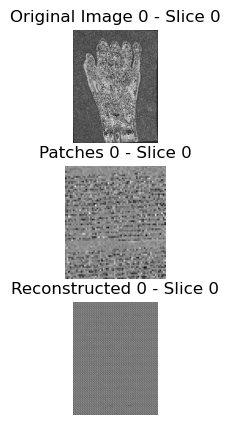

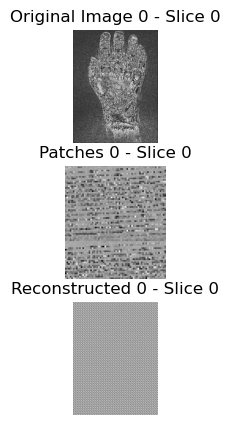

Epoch [1/10], Validation Loss: 98.2518
Epoch [1/10], Loss: 102.9554, L1 Loss: 81.2288, Contrastive Loss: 0.0000


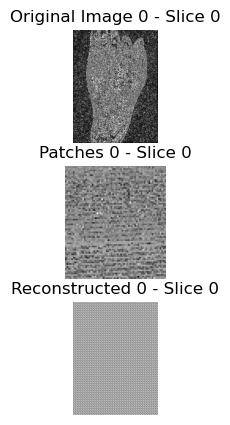

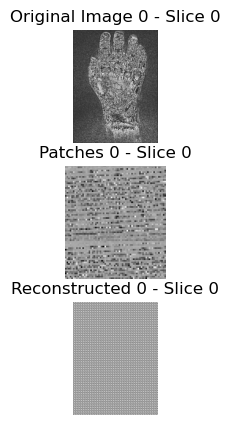

Epoch [2/10], Validation Loss: 98.0821
Epoch [2/10], Loss: 102.3378, L1 Loss: 81.0593, Contrastive Loss: 0.0000


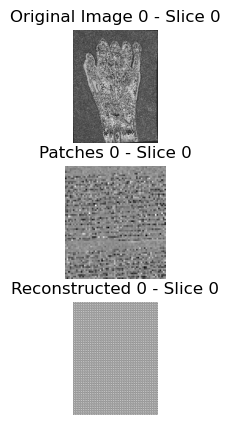

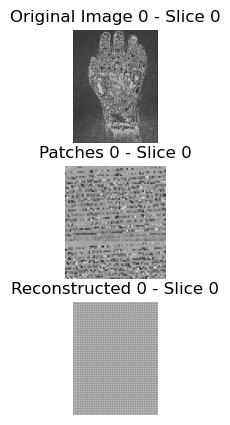

Epoch [3/10], Validation Loss: 97.9240
Epoch [3/10], Loss: 102.1775, L1 Loss: 80.9020, Contrastive Loss: 0.0000


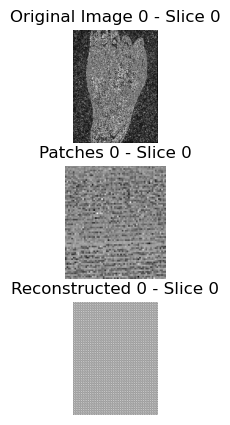

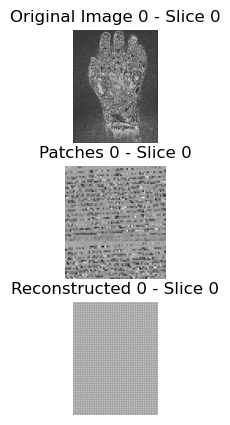

Epoch [4/10], Validation Loss: 97.7512
Epoch [4/10], Loss: 102.0145, L1 Loss: 80.7302, Contrastive Loss: 0.0000


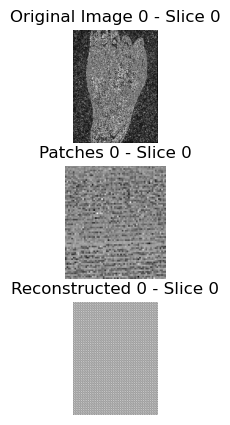

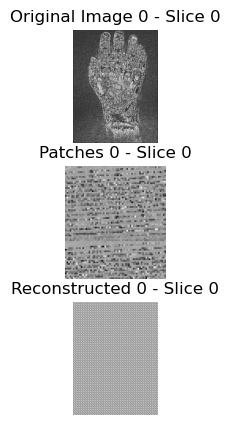

Epoch [5/10], Validation Loss: 97.5721
Epoch [5/10], Loss: 101.8386, L1 Loss: 80.5522, Contrastive Loss: 0.0000


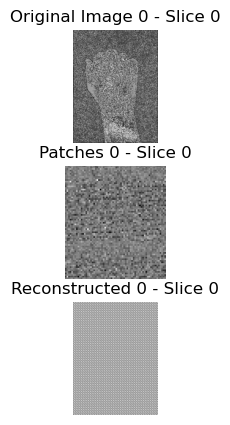

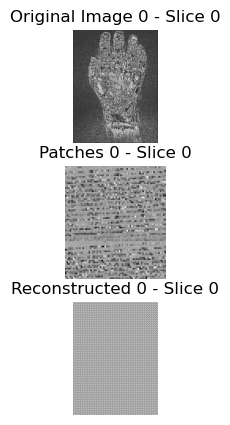

Epoch [6/10], Validation Loss: 97.3900
Epoch [6/10], Loss: 101.6586, L1 Loss: 80.3714, Contrastive Loss: 0.0000


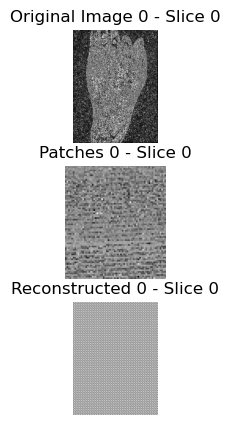

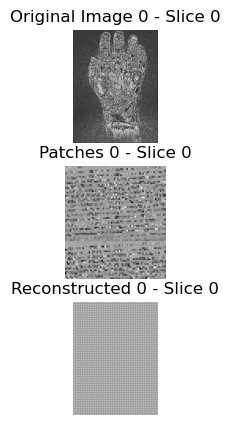

Epoch [7/10], Validation Loss: 97.2032
Epoch [7/10], Loss: 101.4751, L1 Loss: 80.1858, Contrastive Loss: 0.0000


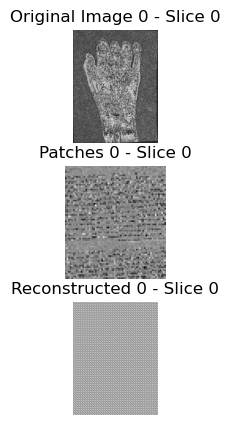

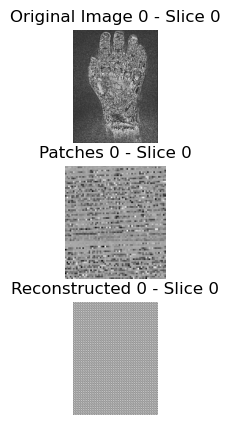

Epoch [8/10], Validation Loss: 97.0068
Epoch [8/10], Loss: 101.2858, L1 Loss: 79.9907, Contrastive Loss: 0.0000


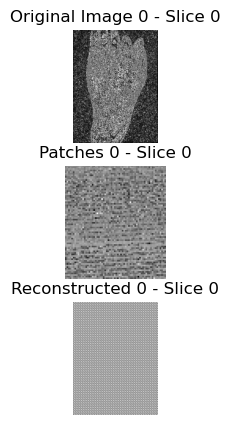

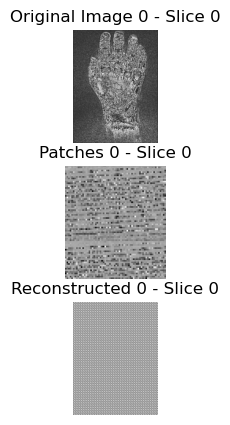

Epoch [9/10], Validation Loss: 96.8033
Epoch [9/10], Loss: 101.0865, L1 Loss: 79.7885, Contrastive Loss: 0.0000


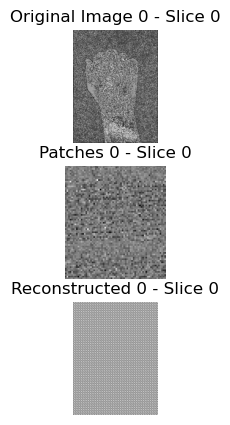

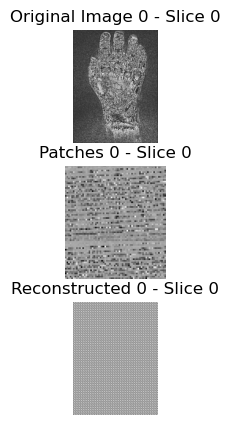

Epoch [10/10], Validation Loss: 96.5953
Epoch [10/10], Loss: 100.8821, L1 Loss: 79.5820, Contrastive Loss: 0.0000


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define the DisruptiveAutoencoder model (this should be done before the training loop)
dae_model = DisruptiveAutoencoder(
    in_channels=1,       # Input channel dimension, typically 1 for grayscale medical images
    patch_size=(1, 4, 4),        # Size of each patch
    embed_dim=64,        # Embedding dimension size
    depth=4,             # Number of transformer layers
    num_heads=4,         # Number of attention heads
    mlp_ratio=4.0        # Ratio of MLP hidden layer dimension to embedding dimension
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dae_model = dae_model.to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(dae_model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Define the EarlyStopper
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

# Training loop
for epoch in range(num_epochs):
    dae_model.train()  # Set model to training mode
    epoch_loss = 0
    for batch_idx, (patches, labels) in enumerate(train_loader):
        patches = patches.to(device)  # Move patches to the same device as the model
        labels = labels.to(device)    # Move labels to the same device as the model

        optimizer.zero_grad()

        # Apply noise, downsampling, and local masking
        noisy_patches = dae_model.add_noise(patches)
        downsampled_patches = dae_model.downsample(noisy_patches)
        
        # Forward pass
        masked_patches = dae_model.local_mask(downsampled_patches)
        reconstructed_patches = dae_model(masked_patches)

        # Generate zsim and zlabel for contrastive learning
        zsim = torch.mm(reconstructed_patches.view(reconstructed_patches.size(0), -1), 
                        reconstructed_patches.view(reconstructed_patches.size(0), -1).T)
        zlabel = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()  # Binary label matrix for positive pairs

        # Compute combined loss
        total_loss, l1_loss, contrastive_loss = dae_model.compute_loss(reconstructed_patches, patches, zsim, zlabel)
        epoch_loss += total_loss.item()

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        # Visualize a few images and their reconstructions
        if batch_idx % 10 == 0:
            visualize_reconstruction(dae_model, patches, batch_idx, device)

    # Validation phase (or calculate validation loss)
    dae_model.eval()  # Set model to evaluation mode
    validation_loss = 0
    with torch.no_grad():
        for batch_idx, (patches, labels) in enumerate(valid_loader):
            patches = patches.to(device)
            labels = labels.to(device)

            # Forward pass
            noisy_patches = dae_model.add_noise(patches)
            downsampled_patches = dae_model.downsample(noisy_patches)
            masked_patches = dae_model.local_mask(downsampled_patches)
            reconstructed_patches = dae_model(masked_patches)

            # Compute loss
            zsim = torch.mm(reconstructed_patches.view(reconstructed_patches.size(0), -1), 
                            reconstructed_patches.view(reconstructed_patches.size(0), -1).T)
            zlabel = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

            _, l1_loss, contrastive_loss = dae_model.compute_loss(reconstructed_patches, patches, zsim, zlabel)
            validation_loss += l1_loss.item()

            # Visualize a few images and their reconstructions
            if batch_idx % 10 == 0:
                visualize_reconstruction(dae_model, patches, batch_idx, device)

    # Average validation loss
    validation_loss /= len(valid_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {validation_loss:.4f}')

    # Check early stopping
    if early_stopper.early_stop(validation_loss):
        # Save model parameters if early stopping criteria are met for the first time
        if early_stopper.activation_count == 1:
            # Generate a timestamp at the moment early stopping is triggered
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            print(f"\nEarly stopping criteria reached!\nSaving model parameters to {results_path}/{timestamp}_optimal_model_weights_epoch_{epoch + 1}.pth\n")
            # Save network parameters and losses
            opt_MLP_filepath = f"{results_path}/{timestamp}_optimal_model_weights_epoch_{epoch + 1}.pth"
            Early_Stop_Epoch = epoch + 1
            torch.save(dae_model.state_dict(), opt_MLP_filepath)

    # Continue training even after early stopping is triggered
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, '
          f'L1 Loss: {l1_loss.item():.4f}, Contrastive Loss: {contrastive_loss.item():.4f}')

